In [2]:
import numpy as np
import scipy
from scipy.linalg import lu_factor, lu_solve
from scipy.linalg import qr, solve_triangular
import matplotlib as mpl
import matplotlib.pyplot as plt
import bspy

# ODE \#6

### $$y''(t)=\begin{pmatrix}-1 & 0 & 1 & 0\cr 0 & -1 & 0 & 1\cr
1 & 0 & -1 & 0\cr 0 & 1 & 0 & -1\cr\end{pmatrix}y(t)-2y'(t),\qquad
y(0)=\begin{pmatrix}0\cr 0.5\cr 1\cr 0.5\cr\end{pmatrix},\qquad
y(1)=\begin{pmatrix}0.7\cr 0.9\cr 0.3\cr 0.1\cr\end{pmatrix}$$

knots: [0.         0.         0.         0.         0.33333333 0.66666667
 1.         1.         1.         1.        ]
t: 0.0 ix: 4 [ 54. -81.  27.   0.] [-9.  9.  0.  0.] [1. 0. 0. 0.]
t: 0.3333333333333333 ix: 5 [ 13.5 -22.5   9.    0. ] [-2.25  0.75  1.5   0.  ] [0.25       0.58333333 0.16666667 0.        ]
t: 0.6666666666666666 ix: 6 [  9.  -22.5  13.5   0. ] [-1.5  -0.75  2.25  0.  ] [0.16666667 0.58333333 0.25       0.        ]
t: 1.0 ix: 6 [  0.  27. -81.  54.] [ 0.  0. -9.  9.] [0. 0. 0. 1.]


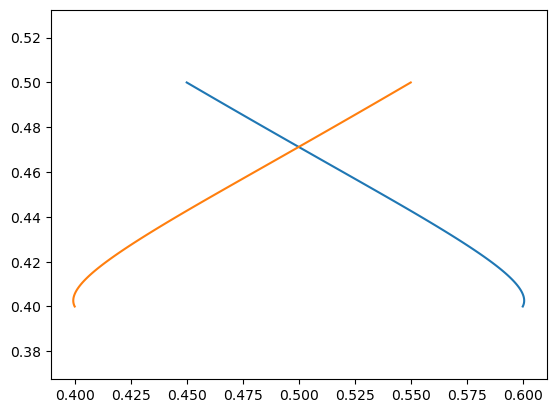

In [30]:
#y1'' = -y1 + y3 - 2y'
#y2'' = -y2 + y4 - 2y'
#y3'' = y1 - y3 - 2y'
#y4'' = y2 - y4 - 2y'

#set parameters
degree = 3
nknots = 2 #interior knots

#create knot vector
knots = np.linspace(0.0, 1.0, nknots + 2)
knots = np.array(degree * [knots[0]] + list(knots) + degree * [knots[-1]]) #add extra knots at beginning and end
print("knots:", knots)


#initialize order and dimension
order = degree + 1
n = len(knots) - order #dimension
#print("dimensions:", n)

collocationpoints = np.linspace(0.0, 1.0, n - 2)
#print("collocation points:", collocationpoints)

#initialize collocation matrix
collocation = np.zeros((4 * n, 4 * n))

#find index of first knot in the array that follows point of evaluation, set Bslipne boundary condition to 0.0 
ix = np.searchsorted(knots, 0.0, side = 'right')
ix = min(ix, n)

#fill collocation matrix with Bspline values at 0.0
bvalues = bspy.Spline.bspline_values(ix, knots, order, 0.0)
collocation[0, 4 * (ix - order) : 4 * ix : 4] = bvalues
collocation[1, 4 * (ix - order) + 1: 4 * ix + 1: 4] = bvalues
collocation[2, 4 * (ix - order) + 2: 4 * ix + 2: 4] = bvalues
collocation[3, 4 * (ix - order) + 3: 4 * ix + 3: 4] = bvalues

#find index of first knot in the array that follows point of evaluation, set Bslipne boundary condition to 1.0 
ix = np.searchsorted(knots, 1.0, side = 'right')
ix = min(ix, n)

#fill collocation matrix with Bspline values at 1.0
bvalues = bspy.Spline.bspline_values(ix, knots, order, 1.0)
collocation[-4, 4 * (ix - order) : 4 * ix : 4] = bvalues
collocation[-3, 4 * (ix - order) + 1: 4 * ix + 1: 4] = bvalues
collocation[-2, 4 * (ix - order) + 2: 4 * ix + 2: 4] = bvalues
collocation[-1, 4 * (ix - order) + 3: 4 * ix + 3: 4] = bvalues
#print("initiallized collocation:", collocation)

for irow, t in enumerate(collocationpoints):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    
    #calculate Bspline and derivative at t
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    bvaluesp = bspy.Spline.bspline_values(ix, knots, order, t, 1)
    bvalues2p = bspy.Spline.bspline_values(ix, knots, order, t, 2)
    print("t:", t, "ix:", ix, bvalues2p, bvaluesp, bvalues)
    
    
#y1'' = -y1 + y3 - 2y'
#y2'' = -y2 + y4 - 2y'
#y3'' = y1 - y3 - 2y'
#y4'' = y2 - y4 - 2y'
    
    
    
    #from the irow values after boundary conditions insert given ode set to 0
    collocation[4 * irow + 4, 4 * (ix - order):4 * ix:4] = bvalues2p + bvalues + 2 * bvaluesp #a 
    #collocation[4 * irow + 4, 4 * (ix - order) + 1:4 * ix + 1:4] = #b
    collocation[4 * irow + 4, 4 * (ix - order) + 2:4 * ix + 2:4] = - bvalues #c
    #collocation[4 * irow + 4, 4 * (ix - order) + 3:4 * ix + 3:4] = #d
    
    #collocation[4 * irow + 5, 4 * (ix - order) :4 * ix:4] = bvalues - 2 * bvaluesp#a
    collocation[4 * irow + 5, 4 * (ix - order) + 1:4 * ix + 1:4] = bvalues2p + bvalues + 2 * bvaluesp #b
    #collocation[4 * irow + 5, 4 * (ix - order) + 2:4 * ix + 2:4] = - bvalues - 2 * bvaluesp#c
    collocation[4 * irow + 5, 4 * (ix - order) + 3:4 * ix + 3:4] = - bvalues #d
    
    collocation[4 * irow + 6, 4 * (ix - order) :4 * ix:4] = - bvalues #a
    #collocation[4 * irow + 6, 4 * (ix - order) + 1:4 * ix + 1:4] = - bvalues - 2 * bvaluesp#b
    collocation[4 * irow + 6, 4 * (ix - order) + 2:4 * ix + 2:4] = bvalues2p + bvalues + 2 * bvaluesp#c
    #collocation[4 * irow + 6, 4 * (ix - order) + 3:4 * ix + 3:4] = bvalues - 2 * bvaluesp#d
    
    #collocation[4 * irow + 7, 4 * (ix - order) :4 * ix:4] = - bvalues - 2 * bvaluesp#a
    collocation[4 * irow + 7, 4 * (ix - order) + 1:4 * ix + 1:4] = - bvalues #b
    #collocation[4 * irow + 7, 4 * (ix - order) + 2:4 * ix + 2:4] = bvalues - 2 * bvaluesp#c
    collocation[4 * irow + 7, 4 * (ix - order) + 3:4 * ix + 3:4] = bvalues2p + bvalues + 2 * bvaluesp#d
    
# Create the right hand side
rhs = np.zeros((4 * n,))
rhs[0] = 0.45
rhs[1] = 0.5
rhs[2]= 0.55
rhs[3] = 0.5
rhs[-4] = 0.6
rhs[-3] = 0.4
rhs[-2] = 0.4
rhs[-1] = 0.4
#print("rhs:", rhs)
#print("c: ", collocation)

# Solve the linear system
lupiv = scipy.linalg.lu_factor(collocation)
alpha = scipy.linalg.lu_solve(lupiv, rhs)
alpha

alpha_u = alpha[0::4]  
alpha_v = alpha[1::4]
alpha_x = alpha[2::4]
alpha_z = alpha[3::4]

#create spline functions
u = bspy.Spline(1, 1, [order], [n], [knots], [alpha_u])
v = bspy.Spline(1, 1, [order], [n], [knots], [alpha_v])
x = bspy.Spline(1, 1, [order], [n], [knots], [alpha_x])
z = bspy.Spline(1, 1, [order], [n], [knots], [alpha_z])

u_values = u(0.0), u(0.5), u(1.0)
v_values = [v(0.0), v(0.5), v(1.0)]
x_values = [x(0.0), x(0.5), x(1.0)]
z_values = [z(0.0), z(0.5), z(1.0)]

#plot
#plt.plot(*u.graph()(np.linspace(0.0,1.0,101)))
tvals = np.linspace(0, 1, 100)
y1_val = u(tvals)
y2_val = v(tvals)
y3_val = x(tvals)
y4_val = z(tvals)
plt.plot(y1_val, y2_val)
plt.plot(y3_val, y4_val)

#tvals = np.linspace(0, 1, 100)
#y1 = np.cos(np.pi * tvals)
#y2 = np.sin(np.pi * tvals)
#plt.plot(y1, y2, 'r')
plt.axis('equal')
plt.show()